In [1]:
import model_utils
import analysis
import logistic

import csv
import math

import xgboost as xgb
import keras
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.style.use('default')

# dataset location
dataset = "./datasets/SHI_modeling_data.csv"

features, labels = model_utils.preprocess(dataset, normalize=True)
train_x, train_y, test_x, test_y = model_utils.split_data(features, labels, 85, 15)

Using TensorFlow backend.
C:\Users\mmode\OneDrive\Nousot\Propensity\model_utils.py:46: RuntimeWarning: invalid value encountered in double_scalars
  entry[i] = (entry[i] - means[i]) / stds[i]


<br></br>
## Model 1
<br></br>

In [2]:
# specify parameters via map
param = {'max_depth':9, 'silent':1, 'objective':'binary:logistic',
         'num_parallel_tree':2,'booster':'gbtree','n_estimators':2,
         'max_delta_step':1,'gamma':0.0,'nthread':4}
num_round = 20

# read in data
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)

best = xgb.train(param, dtrain, num_round)
# make predictions
estimated = (best.predict(dtest)).reshape(len(test_x), 1)

Accuracy:  0.7338888888888889
ZeroR:  0.5305555555555556
Recall:  0.749738219895288
Precision:  0.7489539748953975
Total entries:  1800
True Positive:  716     (40%)
True Negative:  605     (34%)
False Positive:  240    (13%)
False Negative:  239    (13%)
False Positive Rate:  28.402366863905325
False Negative Rate:  25.026178010471206


0.7338888888888889

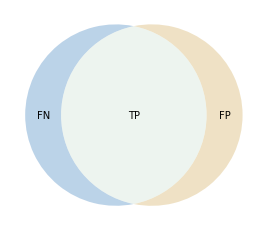

In [3]:
analysis.performance(estimated, test_y, verbose=True, visualize=True)

In [4]:
analysis.detailed(estimated, test_y)

Beat ZeroR accuracy by: 0.203
     0.531 --> 0.734      (38.3% increase)


Best metric: recall
     Precision and recall are balanced     (0.1% difference)




Mean Prediction:  0.54048556
Min Prediction:  0.0036406175
Max Prediction:  0.96903795


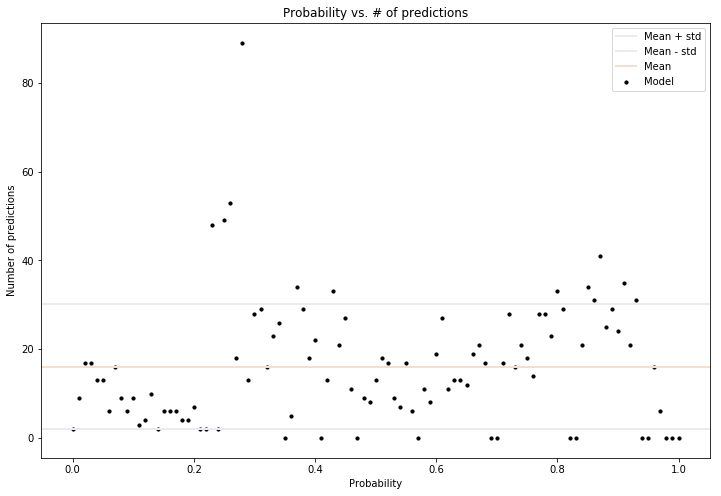

28.94% of observations are outside of 1 standard deviation from the mean


In [5]:
analysis.distribution_metric(estimated, test_y, precision=2, visualize=True, verbose=True)

<br></br>
## Model 2
<br></br>

In [6]:
w, ch = logistic.train(train_x, train_y, 0.1, 100, verbose=False)
lr_estimated = logistic.predict(test_x, w)

Accuracy:  0.5883333333333334
ZeroR:  0.5305555555555556
Recall:  0.8712041884816754
Precision:  0.5737931034482758
Total entries:  1800
True Positive:  832     (46%)
True Negative:  227     (13%)
False Positive:  618    (34%)
False Negative:  123    (7%)
False Positive Rate:  73.13609467455622
False Negative Rate:  12.879581151832461


0.5883333333333334

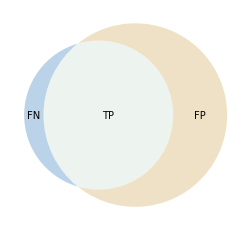

In [7]:
analysis.performance(lr_estimated, test_y, verbose=True, visualize=True)

In [8]:
analysis.detailed(lr_estimated, test_y)

Beat ZeroR accuracy by: 0.058
     0.531 --> 0.588      (10.9% increase)


Best metric: recall
     Model favors recall: casts a wide net - gets tp but also fp     (51.8% difference)




Mean Prediction:  0.5143587821453259
Min Prediction:  8.142296731143992e-07
Max Prediction:  0.801398442177134


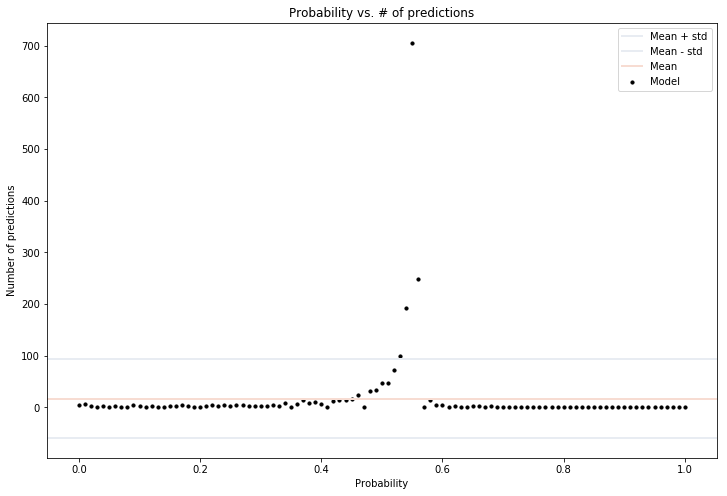

69.22% of observations are outside of 1 standard deviation from the mean


In [9]:
analysis.distribution_metric(lr_estimated, test_y, precision=2, visualize=True, verbose=True)

<br></br>
### Model 3
<br></br>

In [10]:
#get the predictions from LR
w, ch = logistic.train(train_x, train_y, 0.01, 500, verbose=False)
lr_estimated = logistic.predict(test_x, w)

# specify XGBoost parameters via map
param = {'max_depth':9, 'silent':1, 'objective':'binary:logistic',
         'num_parallel_tree':1,'booster':'gbtree','n_estimators':1,
         'max_delta_step':1,'gamma':0.0,'nthread':4}
num_round = 20
#get the predictions from XG
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)

best = xgb.train(param, dtrain, num_round)
# make predictions
xg_estimated = np.array(best.predict(dtest)).reshape(len(test_y), 1)

# create the deep model
model = keras.models.Sequential()
layer_size = 4

model.add(keras.layers.Dense(54, activation='sigmoid'))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(keras.layers.Dense(layer_size))
model.add(keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
model.add(keras.layers.Dense(layer_size))
model.add(keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
model.add(keras.layers.Dense(layer_size))
model.add(keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
model.add(keras.layers.Dense(layer_size))
model.add(keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
model.add(keras.layers.Dense(layer_size))
model.add(keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
model.add(keras.layers.Dense(layer_size))
model.add(keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
model.add(keras.layers.Dense(layer_size))
model.add(keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))

model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam',
            metrics=['accuracy'])
# fit the model
model.fit(train_x, train_y, epochs=150, batch_size=3000, verbose=0)
nn_estimated = model.predict(test_x)

# create the shallow model
model = keras.models.Sequential()
layer_size = 128
model.add(keras.layers.Dense(54, activation='sigmoid'))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(keras.layers.Dense(layer_size))
model.add(keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))

model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam',
            metrics=['accuracy'])
# fit the model
model.fit(train_x, train_y, epochs=150, batch_size=3000, verbose=0)
nn2_estimated = model.predict(test_x)

best = 0.0
weights = None
#brute force find the best weights, yikes
for i in range(10): #lr
    for j in range(10): #xg
        for k in range(10): #nn
            for l in range(10): #nn2
                if i + k + j + l == 10:
                    ensemble = ((i * lr_estimated * .1) + (j * xg_estimated * .1) + (k * nn_estimated * .1) + (l * nn2_estimated * .1))
                    acc = model_utils.performance(ensemble, test_y, verbose=False)
                    if acc >= best:
                        best = acc
                        weights = (i, j, k, l)
print (weights)          
ensemble = ((weights[0] * lr_estimated * .1) + (weights[1] * xg_estimated * .1) + (weights[2] * nn_estimated * .1) + (weights[3] * nn2_estimated * .1))

(5, 2, 0, 3)


Accuracy:  0.745
ZeroR:  0.5305555555555556
Recall:  0.8115183246073299
Precision:  0.7352941176470589
Total entries:  1800
True Positive:  775     (43%)
True Negative:  566     (31%)
False Positive:  279    (16%)
False Negative:  180    (10%)
False Positive Rate:  33.01775147928994
False Negative Rate:  18.848167539267017


0.745

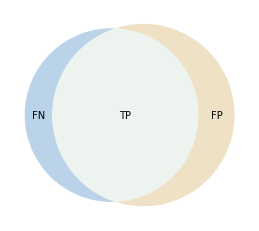

In [11]:
analysis.performance(ensemble, test_y, verbose=True, visualize=True)

In [12]:
analysis.detailed(ensemble, test_y)

Beat ZeroR accuracy by: 0.214
     0.531 --> 0.745      (40.4% increase)


Best metric: recall
     Model favors recall: casts a wide net - gets tp but also fp     (10.4% difference)




Mean Prediction:  0.5275796975671542
Min Prediction:  0.0036206111993140433
Max Prediction:  0.8548457940566689


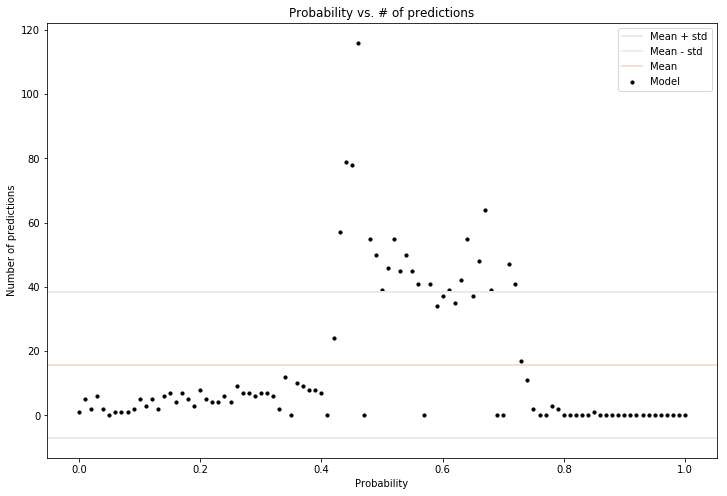

65.11% of observations are outside of 1 standard deviation from the mean


In [13]:
analysis.distribution_metric(ensemble, test_y, precision=2, visualize=True, verbose=True)